In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns

sns.set_theme()

from scripts import *
from models import *

torch.backends.cudnn.benchmark = True

## Data Loading

In [2]:
from torchvision import transforms as T

transforms = nn.Sequential(
    T.Normalize([128., 128., 128.], [128., 128., 128.])
)
scripted_transforms = torch.jit.script(transforms)

dataset = load_images("../Datasets/fruits-360/Training", scripted_transforms)

In [3]:
train_size = int(len(dataset)*0.8)
val_size = len(dataset)-train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

test_set = load_images("../Datasets/fruits-360/Test", scripted_transforms)

In [4]:
test_loader = DataLoader(test_set, batch_size=64, pin_memory=True)
train_loader = DataLoader(train_set, batch_size=16, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=64, pin_memory=True)

### Train classical CNN

In [5]:
cnn = CNN(3, [2,2,2,2,2], [32,64,128,256,512], n_classes=131, activation=nn.GELU, device="cuda")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0006853838367077866)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
cnn.fit(train_loader, optimizer, criterion, n_epochs=20, val_loader=test_loader, scheduler=scheduler)

Epoch: 20	 loss: 0.004301185527557144	 time: 110.1922287940979	val accuracy: 0.9380289316177368


In [7]:
cnn.accuracy(test_loader)

tensor(0.9401, device='cuda:0')

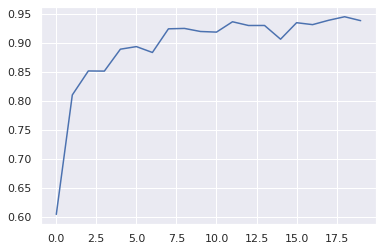

In [6]:
#pl.plot(cnn.losses)
pl.plot(cnn.val_accuracies)

In [25]:
# I use bayesian optimization to find the best hyperparameters
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from time import time

space  = [Real(10**-5, 10**-1, "log-uniform", name='lr'),
          Real(10**-6, 10**-2, "log-uniform", name='weight decay'),
          Categorical([nn.ReLU, nn.LeakyReLU, nn.GELU], name='activation'),
          Real(0.5, 0.99, name='gamma')]

@use_named_args(space)
def objective(**params):
    start = time()
    
    cnn = CNN(3, [2,2,2,2,2], [32,64,128,256,512], n_classes=131, activation=params["activation"], device="cuda")
    optimizer = torch.optim.Adam(cnn.parameters(), lr=params["lr"], weight_decay=params["weight decay"])
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(train_set, batch_size=16, num_workers=1, pin_memory=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, params["gamma"])
    cnn.fit(train_loader, optimizer, criterion, n_epochs=10, verbose=False, scheduler=scheduler)
    
    return (1-cnn.accuracy(val_loader)).item(), time()-start

res_gp = gp_minimize(objective, space, acq_func='EIps', n_calls=50, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 60.9746
Function value obtained: 0.9908
Current minimum: 0.9908
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.1112
Function value obtained: 0.9882
Current minimum: 0.9882
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 60.9955
Function value obtained: 0.9950
Current minimum: 0.9882
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 61.0521
Function value obtained: 0.9897
Current minimum: 0.9882
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 61.2181
Function value obtained: 0.9908
Current minimum: 0.9882
Iteration No: 6 started. Evalu

In [26]:
res_gp.x

[0.0006853838367077866,
 1.3538189391250366e-05,
 torch.nn.modules.activation.GELU,
 0.9794215021118706]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

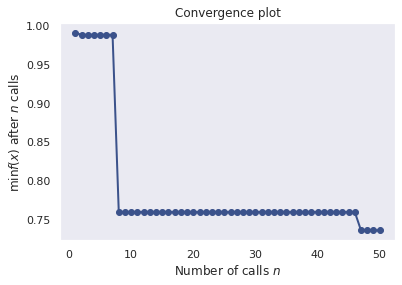

In [27]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)